## Анализ вакансий сайта hh.ru

## Обработка данных

### Загрузка данных из источника

In [128]:
#%pip install pandas
#%pip install numpy
import sqlite3
import pandas as pd
import numpy as np

con = sqlite3.connect("..\db\hhvacancy.db")
cur = con.cursor()
vacancies_frame = pd.read_sql("SELECT * FROM VacancyFullInfo", con)

### Исходные данные

In [129]:
vacancies_frame

,VacancyId,VacancyName,AreaName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,...,ExperienceName,CountersResponses,CountersTotalResponses,HigherEducationMention,SalaryFromClear,SalaryToClear,SalaryMiddleClear,VacancyDescription,KeySkills,ProfessionalRoles
0,101020118,Middle/Senior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:27:40,0,RUR,120000.0,250000.0,...,От 3 до 6 лет,55,55,0,120000.0,250000.0,185000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик"
1,101019344,Junior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:16:57,0,RUR,70000.0,120000.0,...,От 1 года до 3 лет,144,144,0,70000.0,120000.0,95000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик"
2,100426572,PHP / Laravel Developer (Удаленно),Москва,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,137,137,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
3,100426573,PHP / Laravel Developer (Удаленно),Санкт-Петербург,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,102,102,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
4,100426574,PHP / Laravel Developer (Удаленно),Минск,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,118,118,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,99124707,Сетевой инженер (NetOps),Ижевск,ЭДС,0,2024-05-16 09:55:36,0,RUR,80000.0,100000.0,...,От 3 до 6 лет,10,10,0,80000.0,100000.0,90000.0,"<p>Современная и высокотехнологичная компания,...","BGP,L2/L3-коммутация,Linux,Настройка сетевых п...",Сетевой инженер
2378,92438637,QA Automation Engineer Python (MCPTT),Санкт-Петербург,"Протей, НТЦ",0,2024-05-16 09:41:41,0,RUR,150000.0,NaN,...,От 3 до 6 лет,73,167,0,150000.0,NaN,75000.0,<div><strong>ПРОТЕЙ </strong><em>— </em>группа...,"CI/CD,Docker,HTTP,IMS,Linux,PyTest,Python,SIP,...",Тестировщик
2379,97085350,"QA инженер (JS, TS, Selenium)",Москва,Data World,0,2024-05-16 09:32:37,0,RUR,200000.0,210000.0,...,От 1 года до 3 лет,56,228,0,174000.0,182700.0,178350.0,<p><strong>Работа из офиса банка на время прох...,Автотестирование интерфейсов,Тестировщик
2380,99118520,QA-инженер,Нижний Новгород,Фланг,0,2024-05-16 09:14:16,0,RUR,50000.0,90000.0,...,От 1 года до 3 лет,144,144,0,50000.0,90000.0,70000.0,"<p>Привет! В связи с расширением штата, открыт...",None,Тестировщик


### Конвертация валюты заработной платы в рубли

In [130]:
#%pip install requests

In [131]:
# %load wallet_converter
import requests
from xml.etree import ElementTree as ET

def get_exchange_rates(date):
    url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date}'
    response = requests.get(url)
    response.raise_for_status()  # Проверка успешности запроса
    return response.content

def parse_exchange_rates(xml_data):
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()
    
    rates = {}
    for currency in root.findall('Valute'):
        char_code = currency.find('CharCode').text
        value = float(currency.find('Value').text.replace(',', '.'))
        nominal = float(currency.find('Nominal').text.replace(',', '.'))
        rates[char_code] = value / nominal
        
    rates['BYR'] = rates['BYN']
    return rates

def currency_not_rouble(currency):
    return (currency != 'RUB') and (currency != 'RUR')

def convert_currency_internal(amount, from_currency, to_currency, rates): 

    if currency_not_rouble(from_currency):
        amount = amount * rates[from_currency]

    if currency_not_rouble(to_currency):
        amount = amount / rates[to_currency]

    return amount


date = '16/06/2024'  # Дата в формате ДД/ММ/ГГГГ


xml_data = get_exchange_rates(date)
rates = parse_exchange_rates(xml_data)


def convert_currency(amount, from_currency, to_currency):
    return convert_currency_internal(amount, from_currency, to_currency, rates)



In [132]:
vacancies_frame["SalaryMiddleRub"] = vacancies_frame.apply(lambda row: convert_currency(row['SalaryMiddleClear'], row['SalaryCurrency'], 'RUB'), axis=1)

### Подготовка данных для обработки

In [133]:
from sklearn.impute import SimpleImputer

# Удаление дубликатов
vacancies_frame.drop_duplicates(inplace=True)

# Обработка пропущенных значений
# vacancies_frame.dropna(subset=['SalaryMiddleRub', 'ExperienceName', 'KeySkills', 'AreaName'], inplace=True)

# Преобразование категориальных данных с использованием one-hot encoding
categorical_columns = ['AreaName', 'ExperienceName']
vacancies_frame = pd.get_dummies(vacancies_frame, columns=categorical_columns)

# Разделение KeySkills и ProfessionalRoles на отдельные бинарные признаки
skills = vacancies_frame['KeySkills'].str.get_dummies(sep=',')
roles = vacancies_frame['ProfessionalRoles'].str.get_dummies(sep=',')

# Добавление новых бинарных признаков к основному DataFrame
vacancies_frame = pd.concat([vacancies_frame, skills, roles], axis=1)

# Удаление оригинальных текстовых столбцов
vacancies_frame.drop(['KeySkills', 'ProfessionalRoles', 'VacancyId', 'VacancyName', 'EmployerName', 'PublishedAt', 'SalaryCurrency', 'SnippetRequirement', 'SnippetResponsibility', 'VacancyTypeName', 'Url', 'Address', 'AdvResponseUrl', 'Contacts', 'CreatedAt', 'ResponseUrl', 'ScheduleName', 'SortPointDistance', 'EmploymentName', 'VacancyDescription'], axis=1, inplace=True)

# Заполнение пропущенных значений
imputer = SimpleImputer(strategy='mean')
vacancies_frame = pd.DataFrame(imputer.fit_transform(vacancies_frame), columns=vacancies_frame.columns)

# Определение зависимой и независимых переменных
X = vacancies_frame.drop(['SalaryMiddleRub'], axis=1)
y = vacancies_frame['SalaryMiddleRub']

## Информация о наборе данных

### Пример данных

In [134]:
vacancies_frame.head(10)

,HasTest,ResponseLetterRequired,SalaryFrom,SalaryTo,SalaryGross,AcceptTemporary,Archived,CountersResponses,CountersTotalResponses,HigherEducationMention,...,Специалист по кадрам,Специалист по подбору персонала,Специалист по тендерам,Специалист службы безопасности,Специалист технической поддержки,Тестировщик,Технический писатель,Технолог,Упаковщик,Учитель
0,0.0,0.0,120000.0,250000.0,0.0,0.0,0.0,55.0,55.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,70000.0,120000.0,0.0,1.0,0.0,144.0,144.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,2000.0,3000.0,0.0,0.0,0.0,137.0,137.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,2000.0,3000.0,0.0,0.0,0.0,102.0,102.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,2000.0,3000.0,0.0,0.0,0.0,118.0,118.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,3500.0,4500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,200000.0,300000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,275000.0,375000.0,0.0,0.0,0.0,21.0,400.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,100000.0,270000.0,0.0,0.0,0.0,86.0,511.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,2000.0,3500.0,0.0,0.0,0.0,212.0,212.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Информация о типах колонок

In [135]:
vacancies_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Columns: 2308 entries, HasTest to Учитель
dtypes: float64(2308)
memory usage: 41.9 MB


## Описательные статистики

In [136]:
vacancies_frame.describe(include='all')

,HasTest,ResponseLetterRequired,SalaryFrom,SalaryTo,SalaryGross,AcceptTemporary,Archived,CountersResponses,CountersTotalResponses,HigherEducationMention,...,Специалист по кадрам,Специалист по подбору персонала,Специалист по тендерам,Специалист службы безопасности,Специалист технической поддержки,Тестировщик,Технический писатель,Технолог,Упаковщик,Учитель
count,2382.000000,2382.000000,2.382000e+03,2.382000e+03,2382.000000,2382.000000,2382.000000,2382.000000,2382.000000,2382.000000,...,2382.00000,2382.000000,2382.00000,2382.000000,2382.000000,2382.000000,2382.00000,2382.000000,2382.000000,2382.000000
mean,0.030647,0.018472,1.762227e+05,2.864200e+05,0.324097,0.077246,0.000420,59.036524,109.100756,0.036104,...,0.00084,0.002099,0.00084,0.007137,0.036524,0.166247,0.00084,0.006297,0.000420,0.001259
std,0.172394,0.134678,6.827287e+05,1.096833e+06,0.468135,0.267037,0.020489,141.671601,281.348766,0.186588,...,0.02897,0.045777,0.02897,0.084196,0.187629,0.372380,0.02897,0.079121,0.020489,0.035474
min,0.000000,0.000000,1.400000e+02,1.900000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.600000e+04,1.200000e+05,0.000000,0.000000,0.000000,2.000000,7.000000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.200000e+05,2.864200e+05,0.000000,0.000000,0.000000,9.000000,26.000000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.762227e+05,2.864200e+05,1.000000,0.000000,0.000000,46.000000,97.750000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.500000e+07,2.500000e+07,1.000000,1.000000,1.000000,1822.000000,6574.000000,1.000000,...,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


## Анализ колонок

### Конфигурация отрисовки графиков

In [137]:
#%pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline


### Гистограмма откликов по вакансиям с момента публикации

<Axes: >

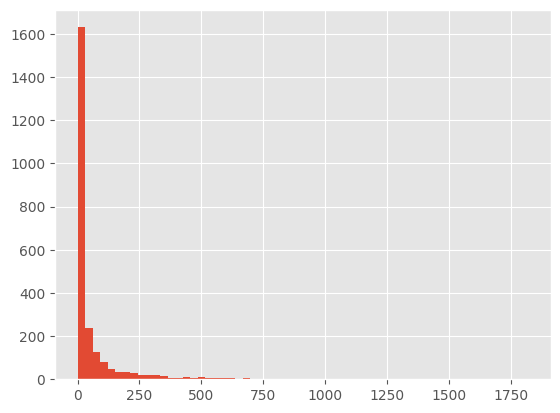

In [138]:
vacancies_frame["CountersResponses"].hist(bins=60)

### Гистограмма откликов по вакансиям с момента создания вакансии

<Axes: >

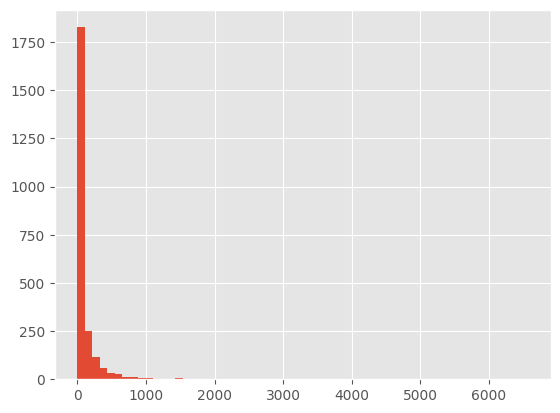

In [139]:
vacancies_frame["CountersTotalResponses"].hist(bins=60)

### Гистограмма по средним зарплатам

<Axes: >

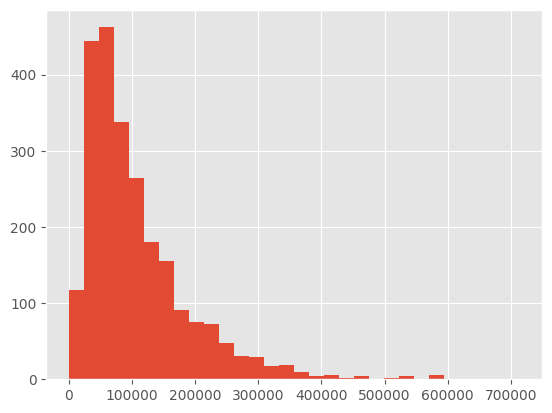

In [140]:
vacancies_frame["SalaryMiddleRub"].hist(bins=30)

# Математическая модель

## Определение модели

In [141]:
# Необходимые импорты
#%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [142]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели линейной регрессии
model = LinearRegression()

# Обучение модели на обучающей выборке
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

## Оценка модели

In [143]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

## Вывод показателей

In [144]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3.0679109885951116e+16
R^2 Score: -4206837.922592888
Mean Absolute Error: 24529930.38069059


## Визуализация результатов

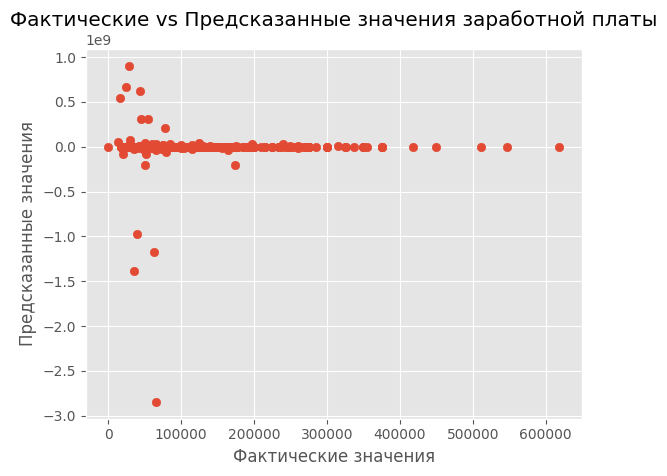

In [145]:
# Визуализация фактических и предсказанных значений
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения заработной платы')
plt.show()

## Анализ коэффициентов регрессии

In [146]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients.head(10))

# Самые важные навыки и роли
important_skills = coefficients[coefficients.index.isin(skills.columns)].head(10)
important_roles = coefficients[coefficients.index.isin(roles.columns)].head(10)

print("Самые важные навыки:")
print(important_skills)

print("Самые важные роли:")
print(important_roles)

                                              Coefficient
Archived                                     2.986672e+10
Проектирование и монтаж систем оповещения    1.892781e+09
проектирование СКС                           1.471723e+09
Электрические системы и слаботочные системы  6.681060e+08
Eltex                                        6.163084e+08
Маршрутизаторы                               6.162801e+08
Hirschmann                                   6.162798e+08
MOXA                                         3.697486e+08
ICP DAS                                      3.697471e+08
MikroTik RouterOS v6/v7                      3.697431e+08
Самые важные навыки:
                                              Coefficient
Проектирование и монтаж систем оповещения    1.892781e+09
проектирование СКС                           1.471723e+09
Электрические системы и слаботочные системы  6.681060e+08
Eltex                                        6.163084e+08
Маршрутизаторы                               6.1628